/tmp/ipykernel_41229/1979428058.py:27: DeprecationWarning: Non-descriptor Image constructor called. This will stop working in 2026. Use create_image instead (with the same arguments).
  input_imageA_cl = cl.Image(ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR,
/tmp/ipykernel_41229/1979428058.py:29: DeprecationWarning: Non-descriptor Image constructor called. This will stop working in 2026. Use create_image instead (with the same arguments).
  input_imageB_cl = cl.Image(ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR,
/tmp/ipykernel_41229/1979428058.py:32: DeprecationWarning: Non-descriptor Image constructor called. This will stop working in 2026. Use create_image instead (with the same arguments).
  temp_image_cl = cl.Image(ctx, cl.mem_flags.READ_WRITE, fmt_gray, shape=(width, height))
/tmp/ipykernel_41229/1979428058.py:33: DeprecationWarning: Non-descriptor Image constructor called. This will stop working in 2026. Use create_image instead (with the same arguments).


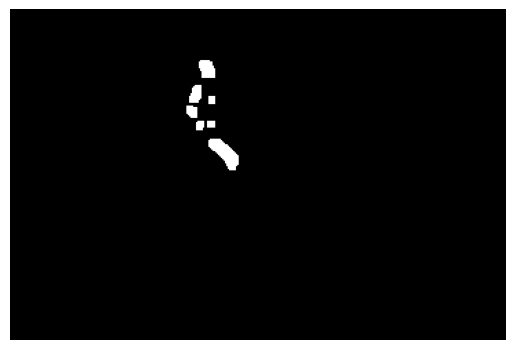

In [2]:
import pyopencl as cl
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Wczytanie obrazów
imageA = np.array(Image.open("/home/plorenc/Desktop/AiR_ISS/AVS/pedestrian/input/in000519.jpg").convert("RGB"), dtype=np.uint8)
imageB = np.array(Image.open("/home/plorenc/Desktop/AiR_ISS/AVS/pedestrian/input/in000520.jpg").convert("RGB"), dtype=np.uint8)

height, width, _ = imageA.shape

# Konwersja na RGBA
imageA_rgba = np.dstack((imageA, np.full((height, width), 255, dtype=np.uint8)))
imageB_rgba = np.dstack((imageB, np.full((height, width), 255, dtype=np.uint8)))

# Tworzenie kontekstu: automatyczne wybranie pierwszego urządzenia
platform = cl.get_platforms()[0]
device = platform.get_devices()[0]
ctx = cl.Context([device])
queue = cl.CommandQueue(ctx)

# Definicje formatów obrazów
fmt_rgba = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.UNORM_INT8)
fmt_gray = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.UNORM_INT8)  # Na końcu konwersja na szarość

# Utworzenie obrazów OpenCL
input_imageA_cl = cl.Image(ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR,
                           fmt_rgba, shape=(width, height), hostbuf=imageA_rgba)
input_imageB_cl = cl.Image(ctx, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR,
                           fmt_rgba, shape=(width, height), hostbuf=imageB_rgba)

temp_image_cl = cl.Image(ctx, cl.mem_flags.READ_WRITE, fmt_gray, shape=(width, height))
output_image_cl = cl.Image(ctx, cl.mem_flags.READ_WRITE, fmt_gray, shape=(width, height))
final_output_image_cl = cl.Image(ctx, cl.mem_flags.WRITE_ONLY, fmt_gray, shape=(width, height))

# Wczytanie kernela
with open("/home/plorenc/Desktop/AiR_ISS/OpenCL/PoCL_distibutet_system/kernel.cl", 'r') as f:
    kernel_code = f.read()

program = cl.Program(ctx, kernel_code).build()

# Kernel 1: median filter
median_kernel = program.median_kernel
median_kernel.set_args(input_imageA_cl, input_imageB_cl, temp_image_cl)
cl.enqueue_nd_range_kernel(queue, median_kernel, (width, height), None)

# Kernel 2: erozja
erode_kernel = program.erode_kernel
erode_kernel.set_args(temp_image_cl, output_image_cl)
cl.enqueue_nd_range_kernel(queue, erode_kernel, (width, height), None)

# Kernel 3: dylatacja
dilate_kernel = program.dilate_kernel
dilate_kernel.set_args(output_image_cl, final_output_image_cl)
cl.enqueue_nd_range_kernel(queue, dilate_kernel, (width, height), None)

# Zczytanie danych z finalnego obrazu
output_np = np.empty((height, width, 4), dtype=np.uint8)
origin = (0, 0, 0)
region = (width, height, 1)
cl.enqueue_copy(queue, output_np, final_output_image_cl, origin=origin, region=region)
queue.finish()

# Konwersja do odcieni szarości
gray_image = np.dot(output_np[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)

# Zapis i wyświetlenie
result = Image.fromarray(gray_image, 'L')
result.save('output_result.jpg')
plt.imshow(result, cmap='gray')
plt.axis('off')
plt.show()


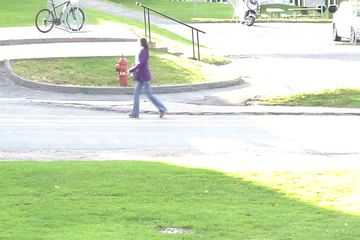

In [ ]:
cl.enq